# DS 2500: Data Wrangling<br>Module Assignment 6
April 19, 2022

Student: Alexander Shahramanyan<br>
Instructor: Professor Marina Kogan

## Introduction
When gas prices rise, it can be a drag on the economy—impacting everything from consumer spending to the price of airline tickets to hiring practices. Gas is an important input for transportation, which directly impacts households as they drive, but also businesses that rely on logistics and transportation chains around the globe.

## Question
- Does the gas price depend on the time of year, i.e., is there seasonality in the gas prices?
- How much does the gas price change affect the inflation rate?

## Dataset Description:
**Weekly US Gas Prices Dataset:** This dataset contains weekly US gas prices from 4/5/1993 to 4/11/2022.
<br>

*Columns*:<br>
2 columns, containing information about:
- Week start - string of date
- Weekly U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon - float

*Number of entries (rows)*: 1515<hr>

**Monthly US Inflation Rates Dataset:** This dataset contains monthly US inflation rates from 1/1914 to 3/2022.
<br>

*Columns*:<br>
16 columns, containing information about:<br>
*Like a pivot-table.*
- Year - the year
- 12 months (Jan-Dec) - inflation rate for each month of the corresponding year
- Annual - the inflation rate for the corresponding year
- HALF1 - the inflation rate for the first half of the corresponding year
- HALF2 - the inflation rate for the second half of the corresponding year

*Number of entries (rows)*: 109

## Setup

First, I import all the libraries I will need throughout the notebook and set the plotting parameters for better visualizations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import textwrap
import statsmodels.api as sm
from fbprophet import Prophet

# Plotting settings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.family'] = 'serif'

C:\Users\alexa\anaconda3\envs\new_environment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Then I need to load the dataset.

In [2]:
# Load data
df = pd.read_csv("Weekly_U.S._All_Grades_All_Formulations_Retail_Gasoline_Prices.csv")

The next step is checking the dataset.

### Dataset Check

In [3]:
# Check dataset shape
df.shape

(1515, 2)

In [4]:
# Check the top of the data
df.head()

,Week of,Weekly U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon
0,4/11/2022,4.196
1,4/4/2022,4.274
2,3/28/2022,4.334
3,3/21/2022,4.343
4,3/14/2022,4.414


In [5]:
# Check the bottom of the data
df.tail()

,Week of,Weekly U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon
1510,5/3/1993,1.086
1511,4/26/1993,1.086
1512,4/19/1993,1.079
1513,4/12/1993,1.079
1514,4/5/1993,1.068


As we can see, the data is in reverse chronological order. I will reverse to get the correct chronological order.

In [6]:
# Reverse the order
df = df.iloc[::-1]
df.head()

,Week of,Weekly U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon
1514,4/5/1993,1.068
1513,4/12/1993,1.079
1512,4/19/1993,1.079
1511,4/26/1993,1.086
1510,5/3/1993,1.086


Also, I will rename the columns to make working with the dataframe easier.

In [7]:
df.rename(columns={"Week of" : "week",\
           "Weekly U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon" : "price"},\
          inplace=True)
df.head()

,week,price
1514,4/5/1993,1.068
1513,4/12/1993,1.079
1512,4/19/1993,1.079
1511,4/26/1993,1.086
1510,5/3/1993,1.086


This looks much better. Then, I will check for missing values.

In [8]:
# Null values
df.isnull().sum().sort_values(ascending=False)

week     0
price    0
dtype: int64

Now, I'll convert the `week` column to datetime.

In [9]:
df["week"] = pd.to_datetime(df["week"])
df.reset_index(drop=True, inplace=True)
df.head()

,week,price
0,1993-04-05,1.068
1,1993-04-12,1.079
2,1993-04-19,1.079
3,1993-04-26,1.086
4,1993-05-03,1.086


In [10]:
# Data description
df.describe()

,price
count,1515.000000
mean,2.255733
std,0.895059
min,0.949000
25%,1.354500
50%,2.292000
75%,2.919000
max,4.414000


### Time Series Exploration

First, I will plot the whole data and find out if any trends can be found just by looking at the graph.

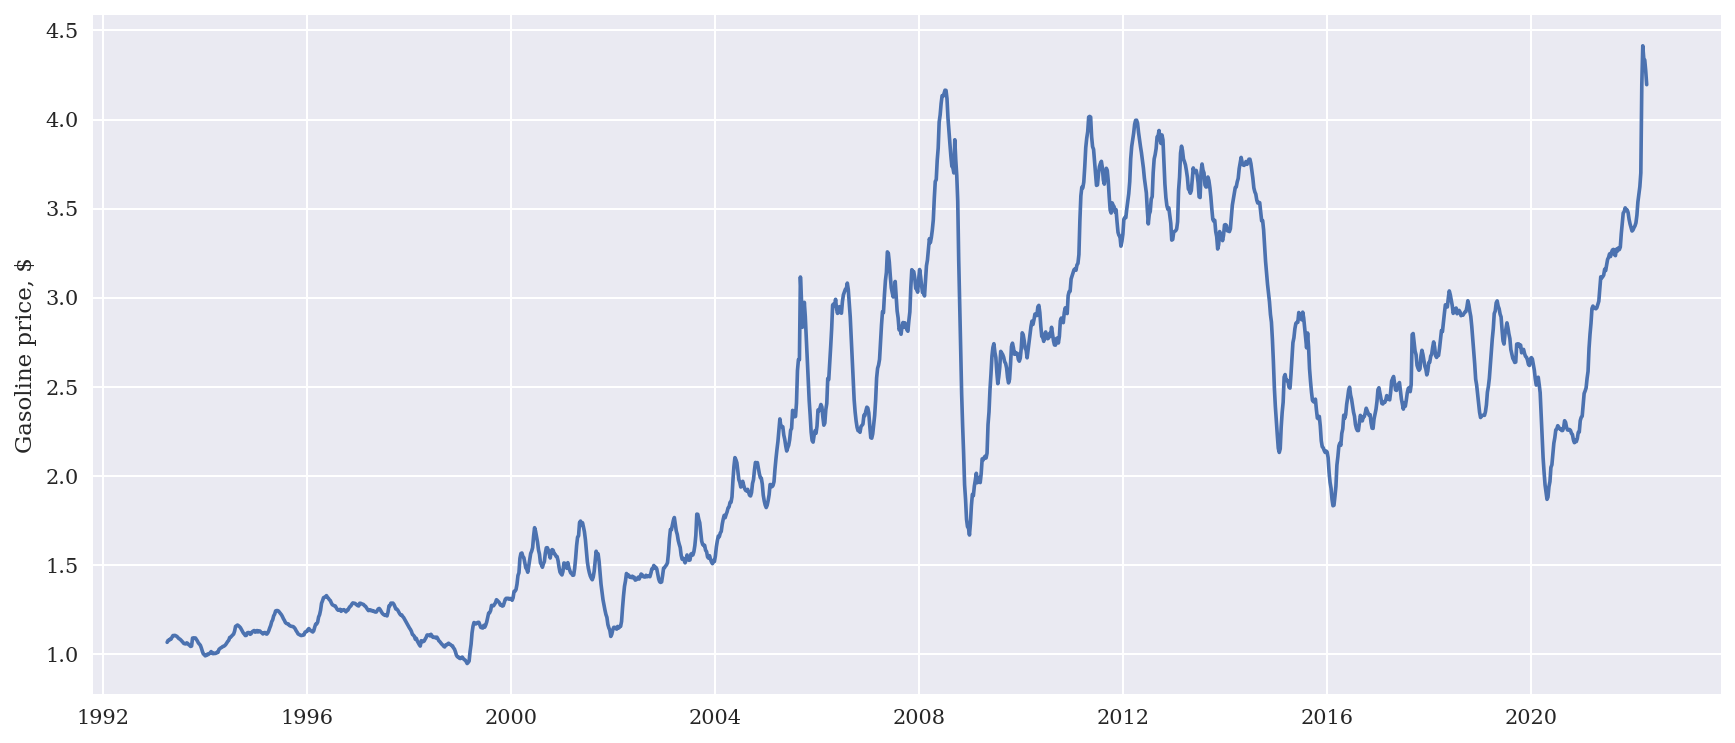

In [11]:
# Plot the data
plt.plot(df.week, df.price)
plt.ylabel('Gasoline price, $')
plt.show()

The first thing I can see is that gasoline prices have increased more than 4 times since 1993. I can also see the effects of the 2008 financial crisis, the increase in the prices followed by a steady decrease. Other than that, gasoline prices have been increasing since 2020, and there has been a particular spike since around February 2022. These are caused by the COVID-19 pandemic and the Russian invasion of Ukraine, respectively. However, I can't find any seasonality by looking at the graph. The overall trend of the prices is increasing, which is reasonable. Major events that affect the economy can be detected on the graph by just looking at it, but not the seasonality or any specific patterns.

I will plot the moving average over 6 months and 1 year. This will show the underlying trends if there are any.

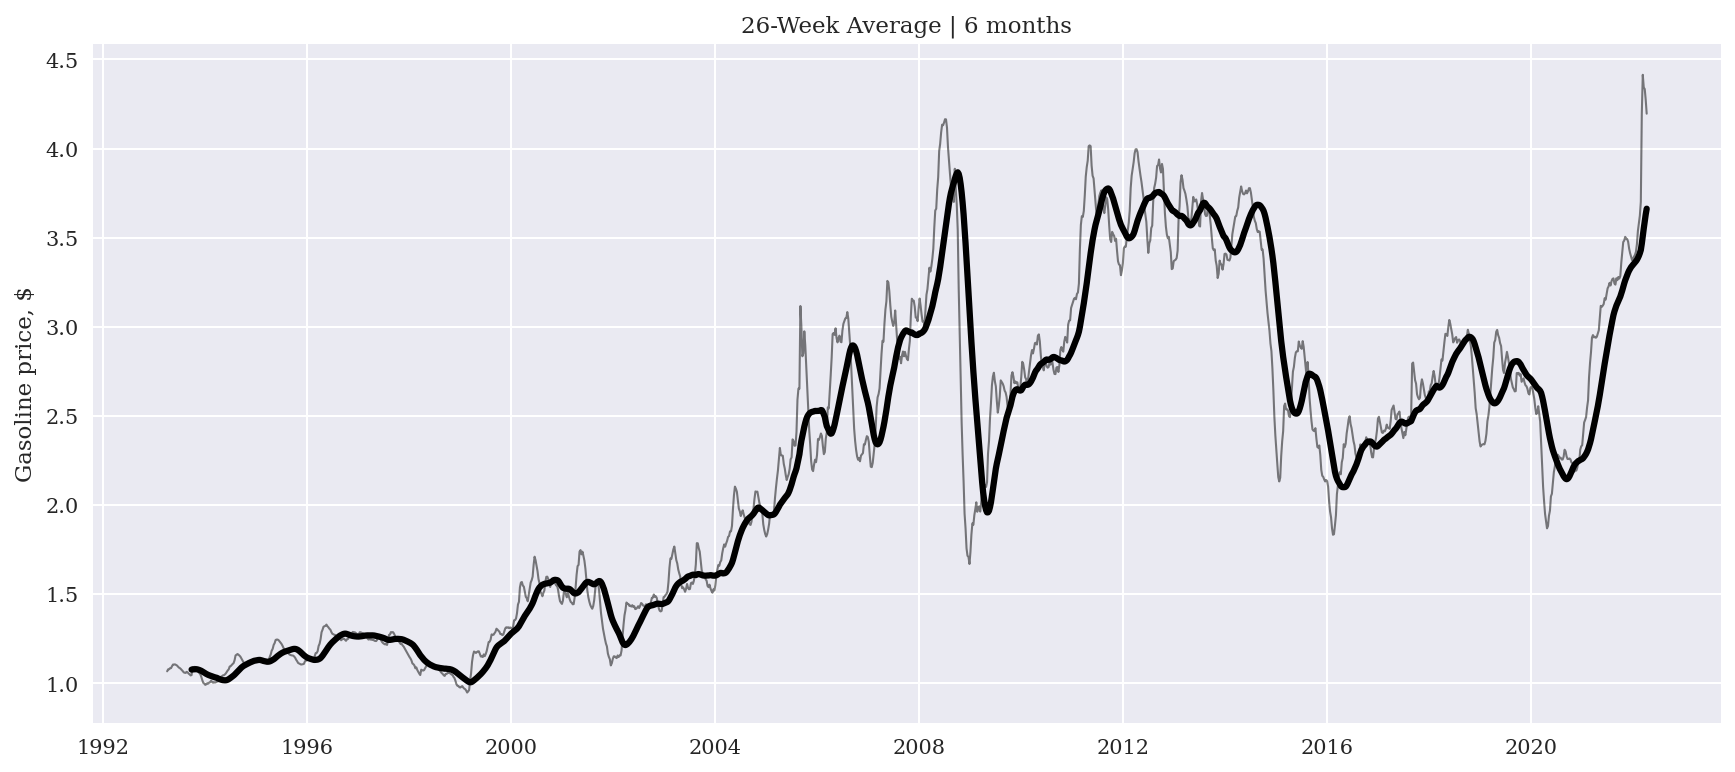

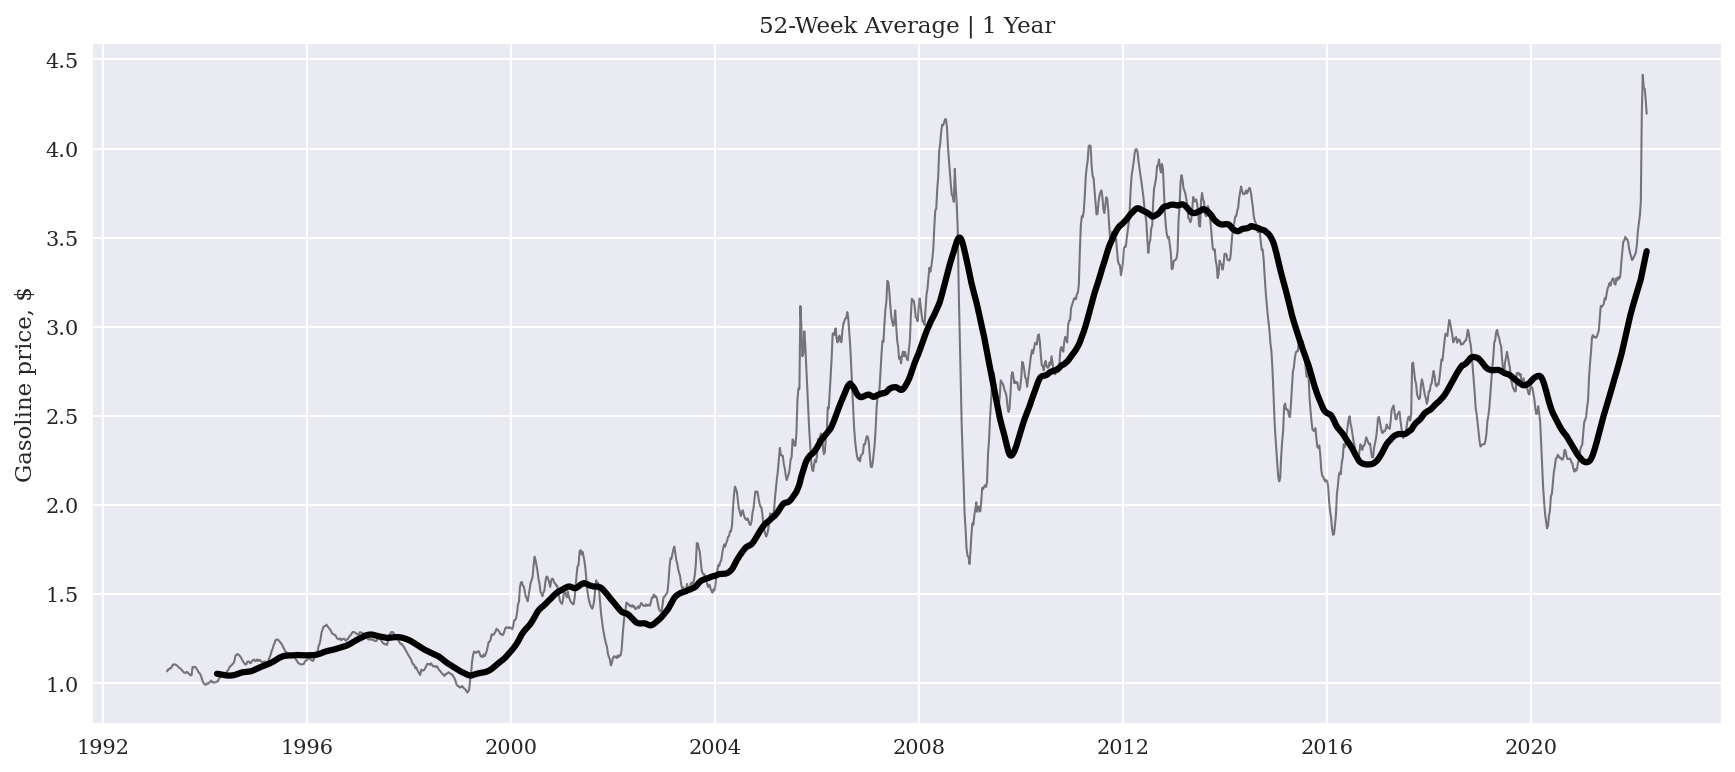

In [12]:
# Plot moving average over 6 months and 1 year
for interval in [26, 52]:
    plt.plot(df['week'], df['price'].rolling(interval).mean(), lw=3, color='k')
    plt.plot(df['week'], df['price'], lw=1, color='k', alpha=.5)
    plt.ylabel('Gasoline price, $')
    plt.title(f"{interval}-Week Average | {'6 months' if interval == 26 else '1 Year'}")
    plt.show()
    plt.close()

Again, the 2008 and 2020-2022 rapid price changes are seen in the moving average lines, but no underlying trend can be found.

Next, I will decompose the time-series into its trend, seasonality, and residual components using the `seasonal_decompose` function from the `statsmodels` library.

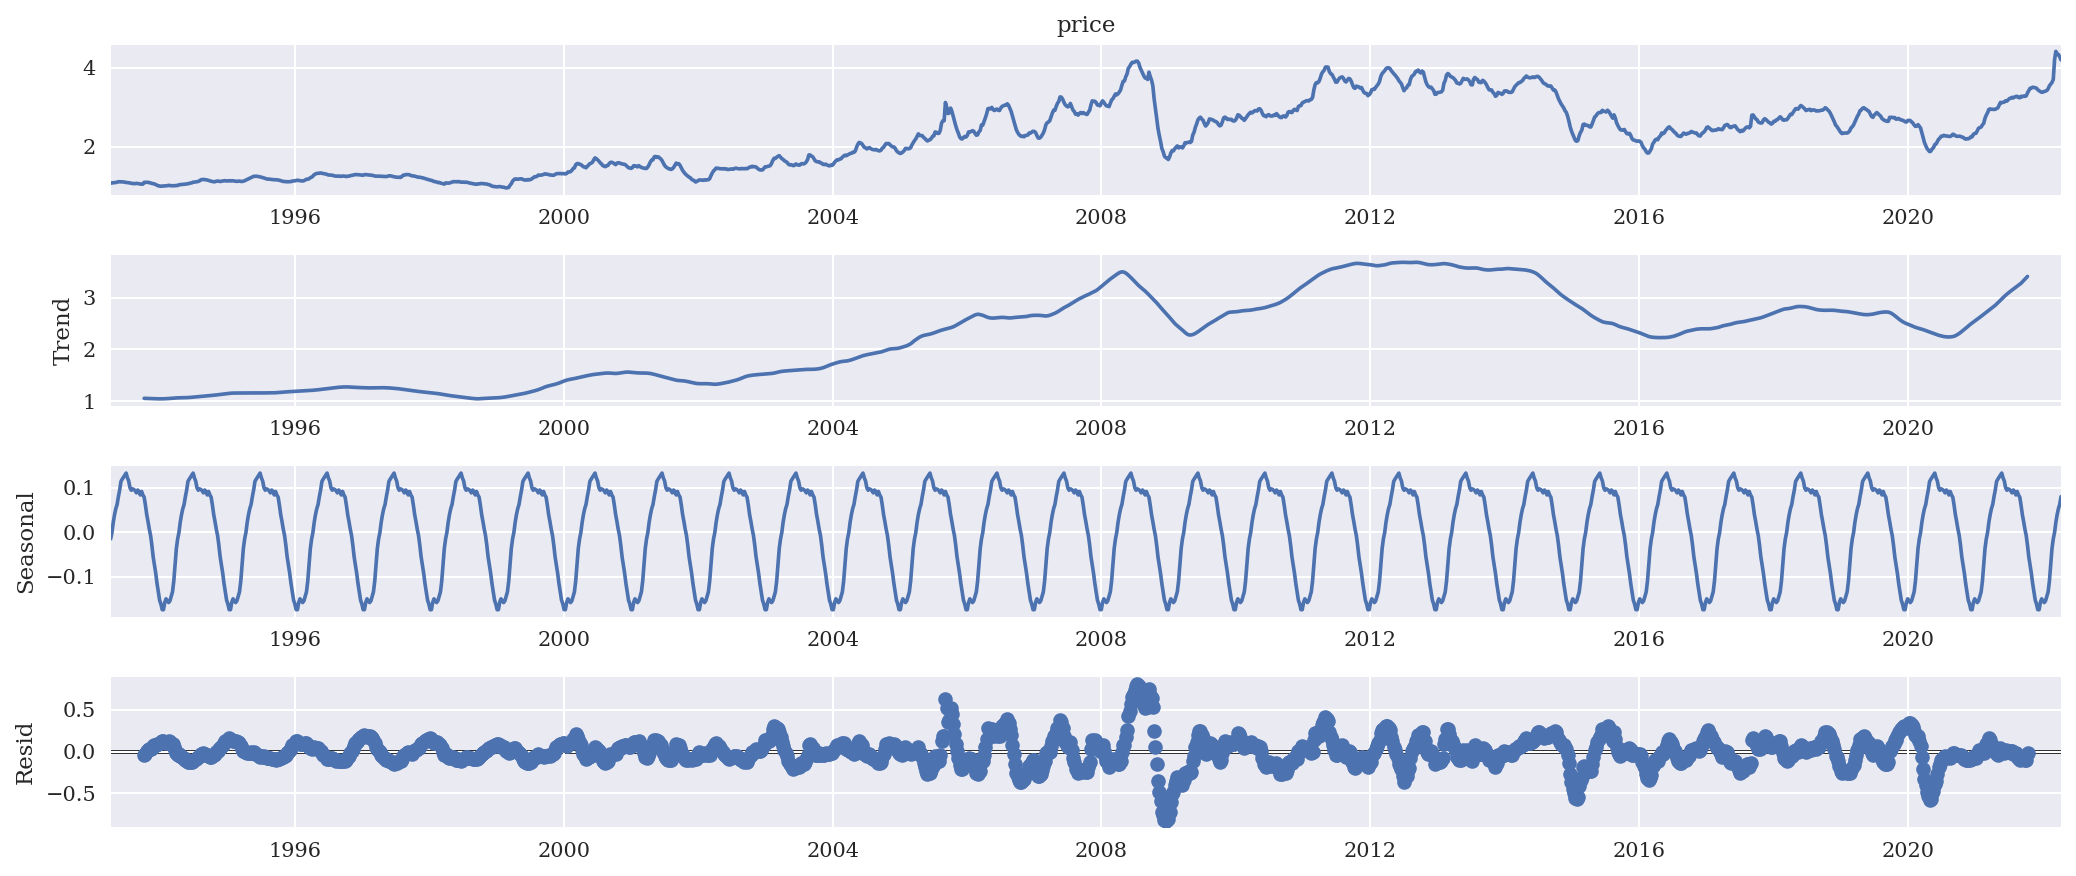

In [13]:
# Seasonal decompose, to find trend, seasonality, and the effect residual factors
decomposition = sm.tsa.seasonal_decompose(df.set_index('week')['price'], model='additive')

decomposition.plot()

plt.show()

As can be seen, the trend looks a lot like the moving average plotted before. Other than that, there actually is some seasonal component: there is an annual seasonality, which seems to be weak (scaling is -0.1 to 0.1) but I think it should be taken into account. Also, the residual component reflects the 2008 financial crisis effect, but not the recent events' impact on the price.

To ensure the said seasonality indeed is in the gas price data, I will plot the gas price with some vertical lines marking the start, middle, and end of the years. The lines in mid-summer should be small peaks.

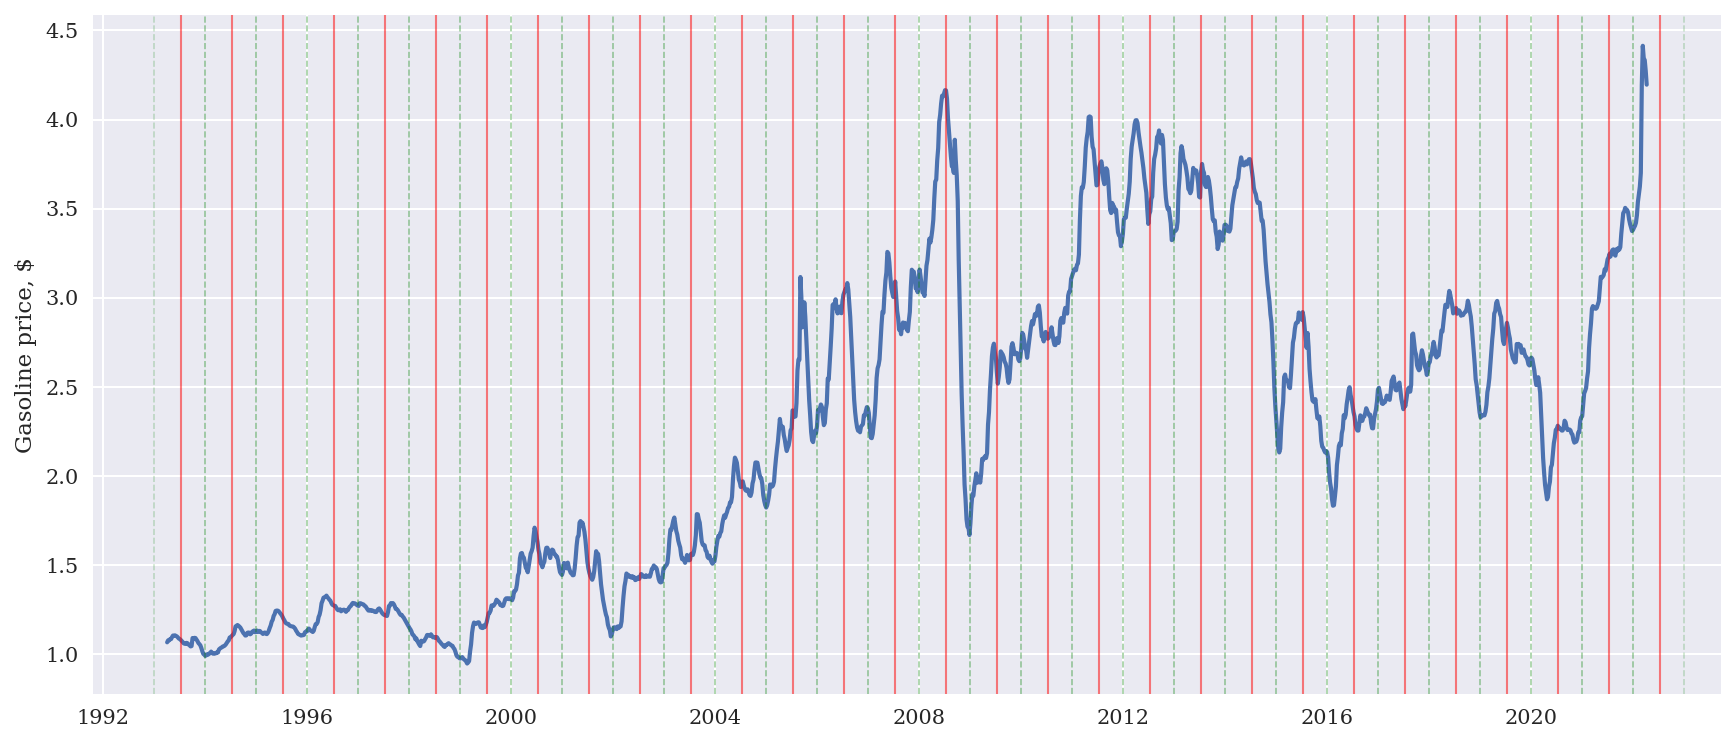

In [14]:
# Plot the data
fig, ax = plt.subplots(1,1)
ax.plot(df.week, df.price, lw=2)
plt.ylabel('Gasoline price, $')

for year in set(df.week.dt.year):
    ax.axvline(pd.Timestamp(f'{year}-01-01'), c='g', ls='--', lw=0.8, alpha=0.2)
    ax.axvline(pd.Timestamp(f'{year}-07-15'), c='r', ls='-', lw=1, alpha=0.5)
    ax.axvline(pd.Timestamp(f'{year}-12-31'), c='g', ls='--', lw=0.8, alpha=0.2)

plt.show()

In the plot, green dashed lines represent the start and end of the year, while the red solid line represents mid-summer (July 15). Indeed, the peaks for each year are very close to the red solid lines, i.e., gas prices peak around July 15.

I will find the autocorrelation and partial autocorrelation to see if there is indeed any annual pattern in the gasoline prices. To do it, I will use the `plot_acf` and `plot_pacf` functions of the `statsmodels` library. Before that, I will get a monthly data from the weekly data

In [15]:
# Make data monthly
monthly = df.set_index('week').resample('1M').mean()
monthly.head()

,price
week,
1993-04-30,1.07800
1993-05-31,1.10040
1993-06-30,1.09725
1993-07-31,1.07775
1993-08-31,1.06160


C:\Users\alexa\anaconda3\envs\new_environment\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


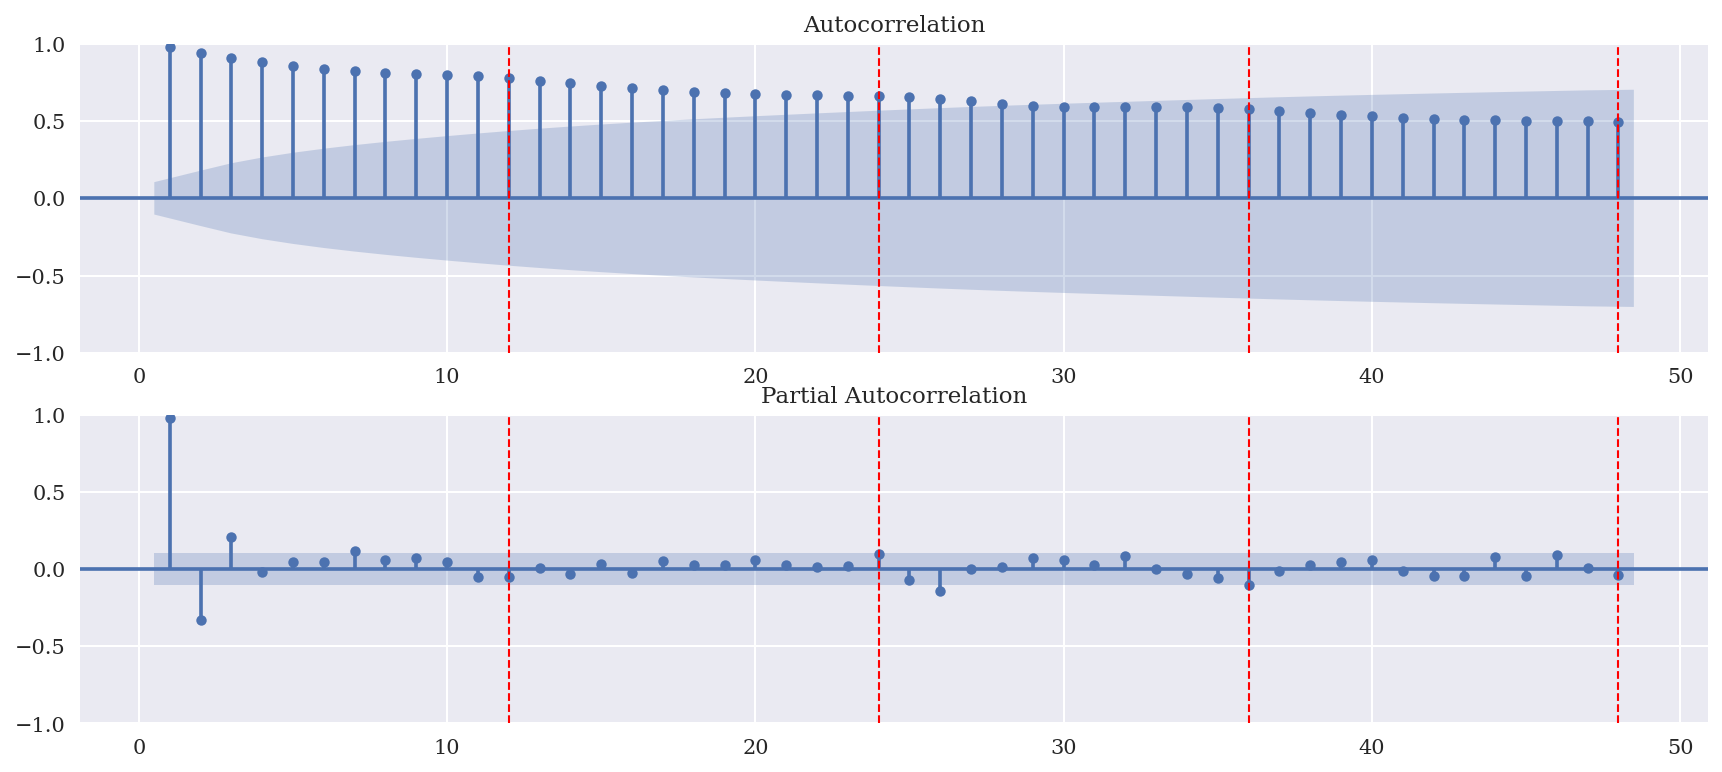

In [16]:
# Autocorrelation and Partial Autocorrelation
f, axs = plt.subplots(2, 1)

fig1 = sm.graphics.tsa.plot_acf(monthly['price'], zero=False, lags=48, ax=axs[0], alpha=.05)
fig2 = sm.graphics.tsa.plot_pacf(monthly['price'], zero=False, lags=48, ax=axs[1], alpha=.05)

for ax in axs:
    ax.axvline(12,c='r',ls='--',lw=1)
    ax.axvline(24,c='r',ls='--',lw=1)
    ax.axvline(36,c='r',ls='--',lw=1)
    ax.axvline(48,c='r',ls='--',lw=1)

Even though the `seasonal_decompose` found some seasonality, the partial autocorrelation does not suggest any relationship between the time series data. The red vertical lines are at 1, 2, 3, and 4 years. Also, there are no peaks in the autocorrelation plot, which supports the previous claim that there is no strong seasonality.

Other than that, I have another idea to test. As far as I understand, gas prices affect account for the increase in the inflation rates. I will plot monthly inflation rates with the gasoline prices, to see the relationship between the two.

### Dataset Check

In [17]:
# Load data
inflation = pd.read_csv("inflation.csv")

In [18]:
# Check dataset shape
inflation.shape

(109, 16)

In [19]:
# Check the top of the data
inflation.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,1914,2.0,1.0,1.0,0.0,2.1,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,,
1,1915,1.0,1.0,0.0,2.0,2.0,2.0,1.0,-1.0,-1.0,1.0,1.0,2.0,1.0,,
2,1916,3.0,4.0,6.1,6.0,5.9,6.9,6.9,7.9,9.9,10.8,11.7,12.6,7.9,,
3,1917,12.5,15.4,14.3,18.9,19.6,20.4,18.5,19.3,19.8,19.5,17.4,18.1,17.4,,
4,1918,19.7,17.5,16.7,12.7,13.3,13.1,18.0,18.5,18.0,18.5,20.7,20.4,18.0,,


In [20]:
# Check the bottom of the data
inflation.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
104,2018,2.1,2.2,2.4,2.5,2.8,2.9,2.9,2.7,2.3,2.5,2.2,1.9,2.4,2.5,2.4
105,2019,1.6,1.5,1.9,2.0,1.8,1.6,1.8,1.7,1.7,1.8,2.1,2.3,1.8,1.7,1.9
106,2020,2.5,2.3,1.5,0.3,0.1,0.6,1.0,1.3,1.4,1.2,1.2,1.4,1.2,1.2,1.2
107,2021,1.4,1.7,2.6,4.2,5.0,5.4,5.4,5.3,5.4,6.2,6.8,7.0,4.7,3.4,6.0
108,2022,7.5,7.9,8.5,,,,,,,,,,,,


In [21]:
# Null values
inflation.isnull().sum().sort_values(ascending=False)

Year      0
Jan       0
Feb       0
Mar       0
Apr       0
May       0
Jun       0
Jul       0
Aug       0
Sep       0
Oct       0
Nov       0
Dec       0
Annual    0
HALF1     0
HALF2     0
dtype: int64

In [22]:
# Change the df structure
inflation.drop(columns=['Annual','HALF1', 'HALF2'], inplace=True)
inflation = inflation.rename(columns={"Year":'year'}).melt(id_vars='year', var_name="month", value_name='inflation')
inflation['date'] = pd.to_datetime(inflation['year'].astype('str') + " " + inflation['month'], format="%Y %b")
inflation = inflation[['date', 'inflation']]
inflation = inflation.sort_values('date').reset_index(drop=True)
inflation = inflation.replace(' ', np.nan).dropna(how='any')
inflation['inflation'] = inflation['inflation'].astype('float')
inflation = inflation[inflation['date'] >= df['week'].iloc[0]]

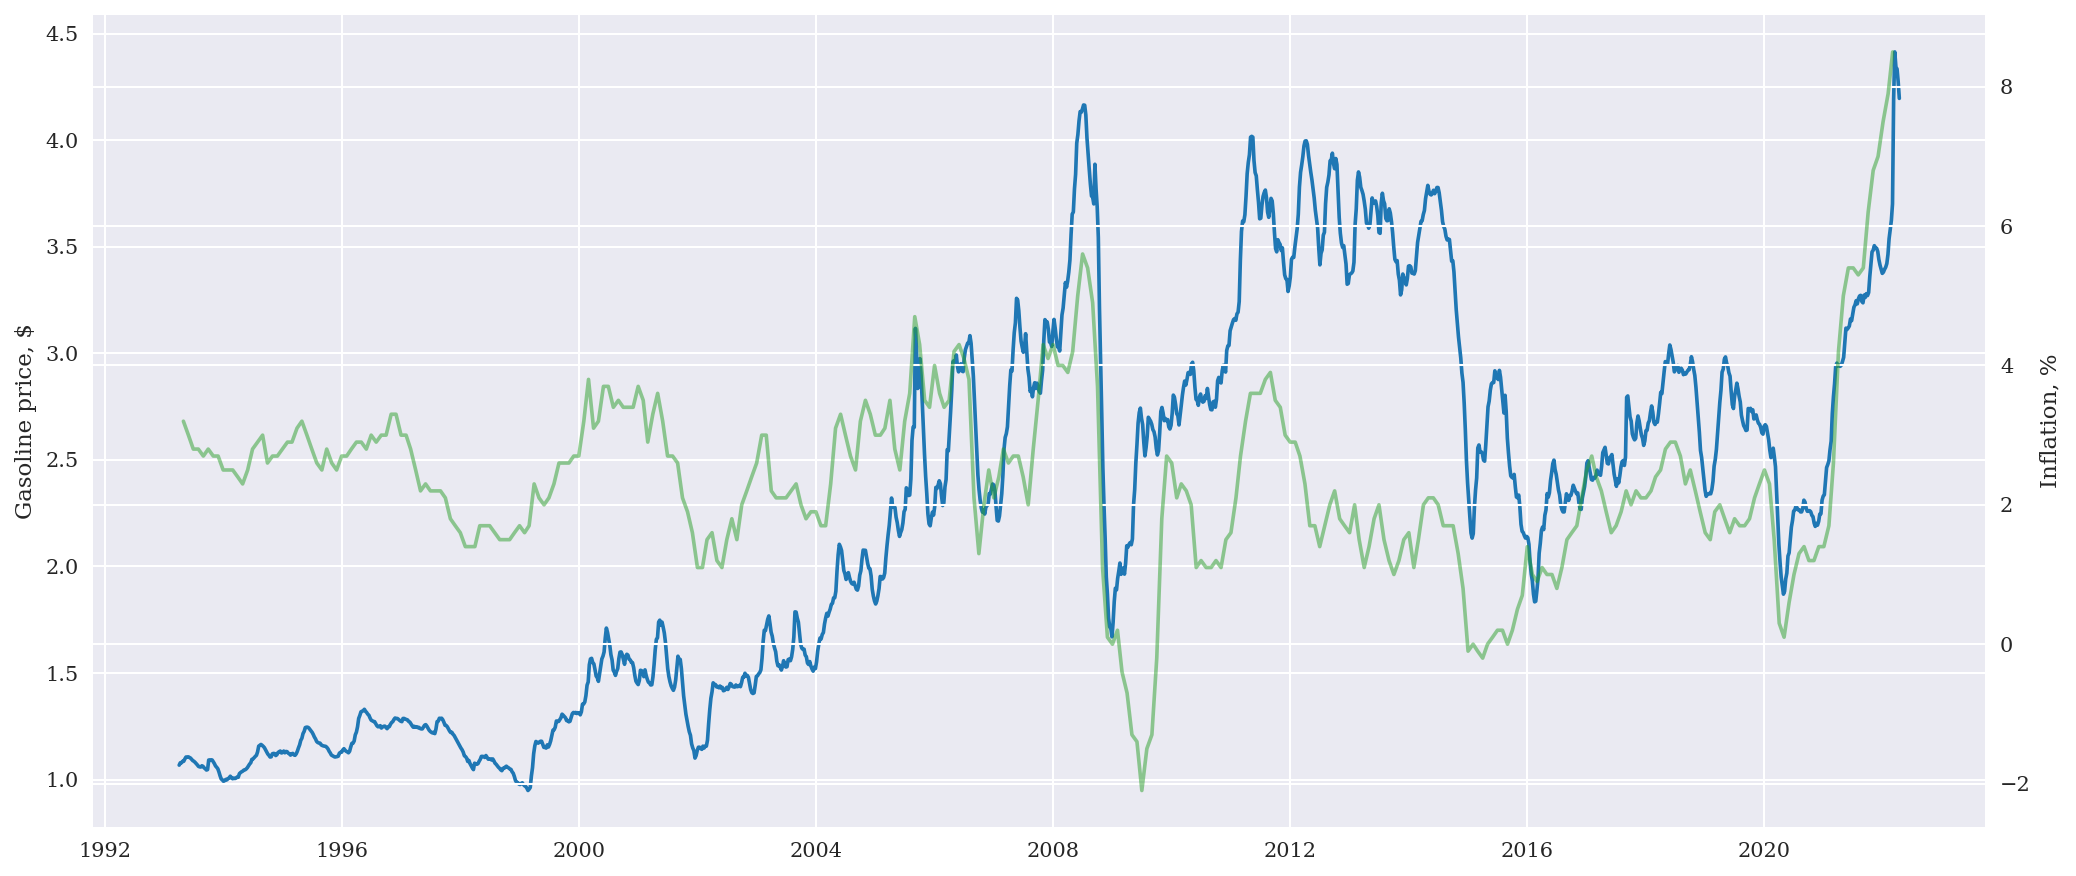

In [23]:
fig, ax1 = plt.subplots()

ax1.set_ylabel('Gasoline price, $')
ax1.plot(df['week'], df['price'], color='tab:blue')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_ylabel('Inflation, %')
ax2.plot(inflation['date'], inflation['inflation'], color='tab:green', alpha=0.5)
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

Even though the US economy is not as dependent on oil as it used to be, oil still is a big contributor to inflation. We can see that as gas price increases, the inflation rate also increases, and as gas price decreases, the inflation rate also decreases. Lastly, I will find the Pearson correlation coefficient. Although, as I look at the graph and see a clear correlation, I do not think it is purely linear and I am not sure the Pearson correlation coefficient will be big enough.

In [24]:
# Pearson correlation coefficient
pearsonr(monthly.iloc[1:-1]['price'], inflation['inflation'])

(0.14751465916843887, 0.005904192810543515)

As expected, the Pearson correlation coefficient is 0.147. The p-value ensures the returned coefficient is statistically significant.

## Predictions

Currently, the US economy is quite unstable because of the ban on the import of Russian oil and gas, hence predicting the future gas prices will not give good results. Nonetheless, I will use Facebook's Prophet to predict the gas prices for the next year. We will be able to check how good the predictions are later.

In [25]:
# Copy the relevant columns to a new DataFrame
prophet_df = df[['week', 'price']].copy()

# Rename the columns how Prophet wants
prophet_df.rename(columns={'week':'ds', 'price':'y'}, inplace=True)

# Inspect
prophet_df.head()

,ds,y
0,1993-04-05,1.068
1,1993-04-12,1.079
2,1993-04-19,1.079
3,1993-04-26,1.086
4,1993-05-03,1.086


In [26]:
m = Prophet(daily_seasonality=False).fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
C:\Users\alexa\anaconda3\envs\new_environment\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [27]:
m_future = m.make_future_dataframe(periods=52, freq='W')

# Inspect the tail to make sure it's weekly
m_future.tail()

,ds
1562,2023-03-12
1563,2023-03-19
1564,2023-03-26
1565,2023-04-02
1566,2023-04-09


In [28]:
m_forecast = m.predict(m_future)

# Lots of columns returned, just look at the chosen ones
m_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

C:\Users\alexa\anaconda3\envs\new_environment\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\alexa\anaconda3\envs\new_environment\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
1562,2023-03-12,3.143064,2.762864,3.543694
1563,2023-03-19,3.168706,2.780284,3.548135
1564,2023-03-26,3.187653,2.793277,3.561967
1565,2023-04-02,3.200714,2.791672,3.563453
1566,2023-04-09,3.208712,2.827399,3.596842


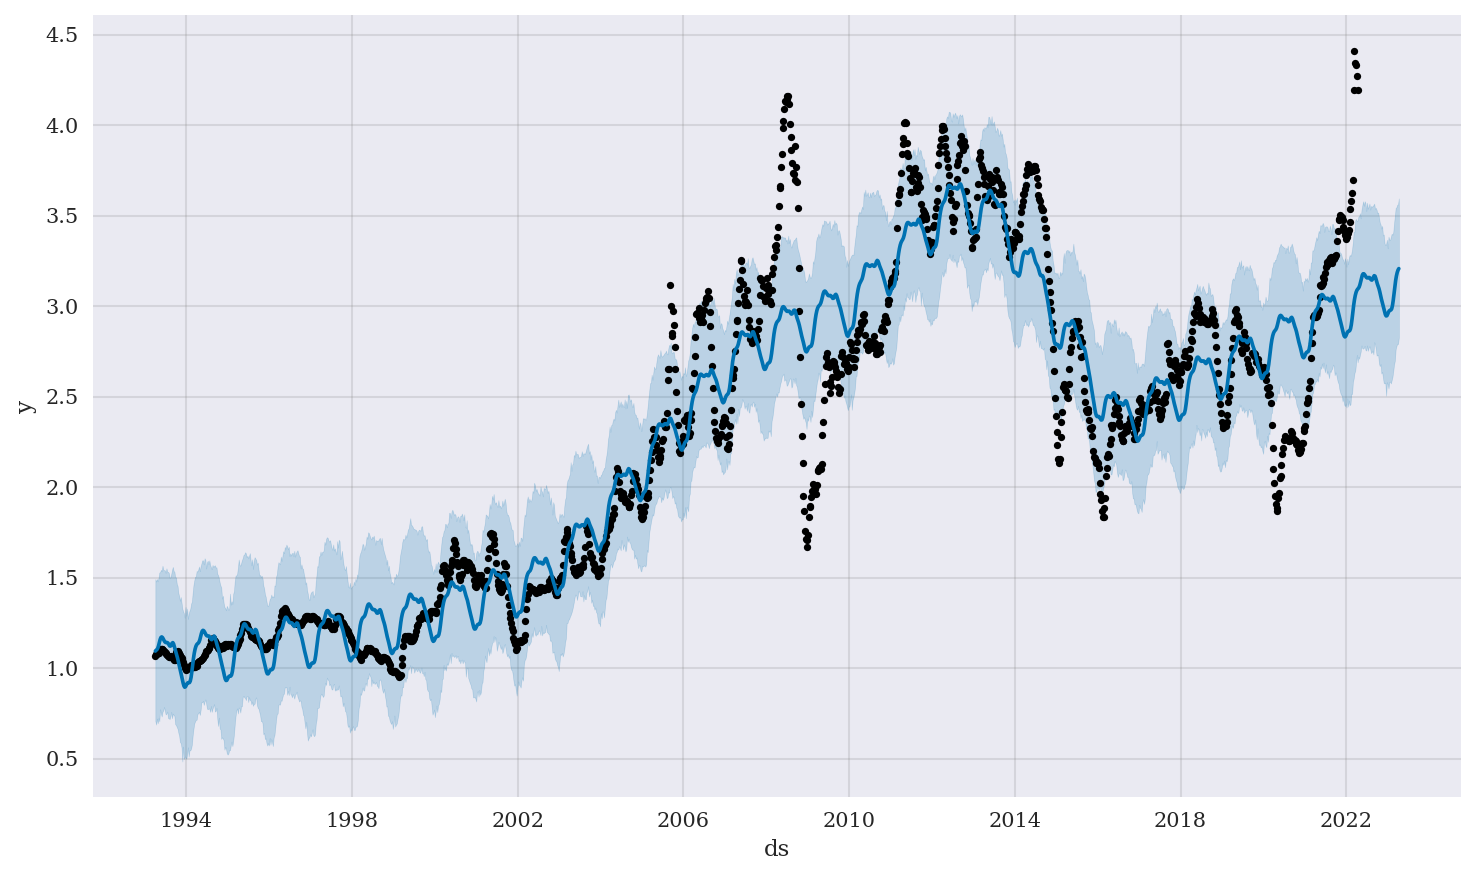

In [29]:
m.plot(m_forecast)

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Observation and Forecast of Gas Prices')

plt.show()

The resulting line returned by Prophet looks good enough except for the crises times when the line is off the original price line by quite a bit.

C:\Users\alexa\anaconda3\envs\new_environment\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


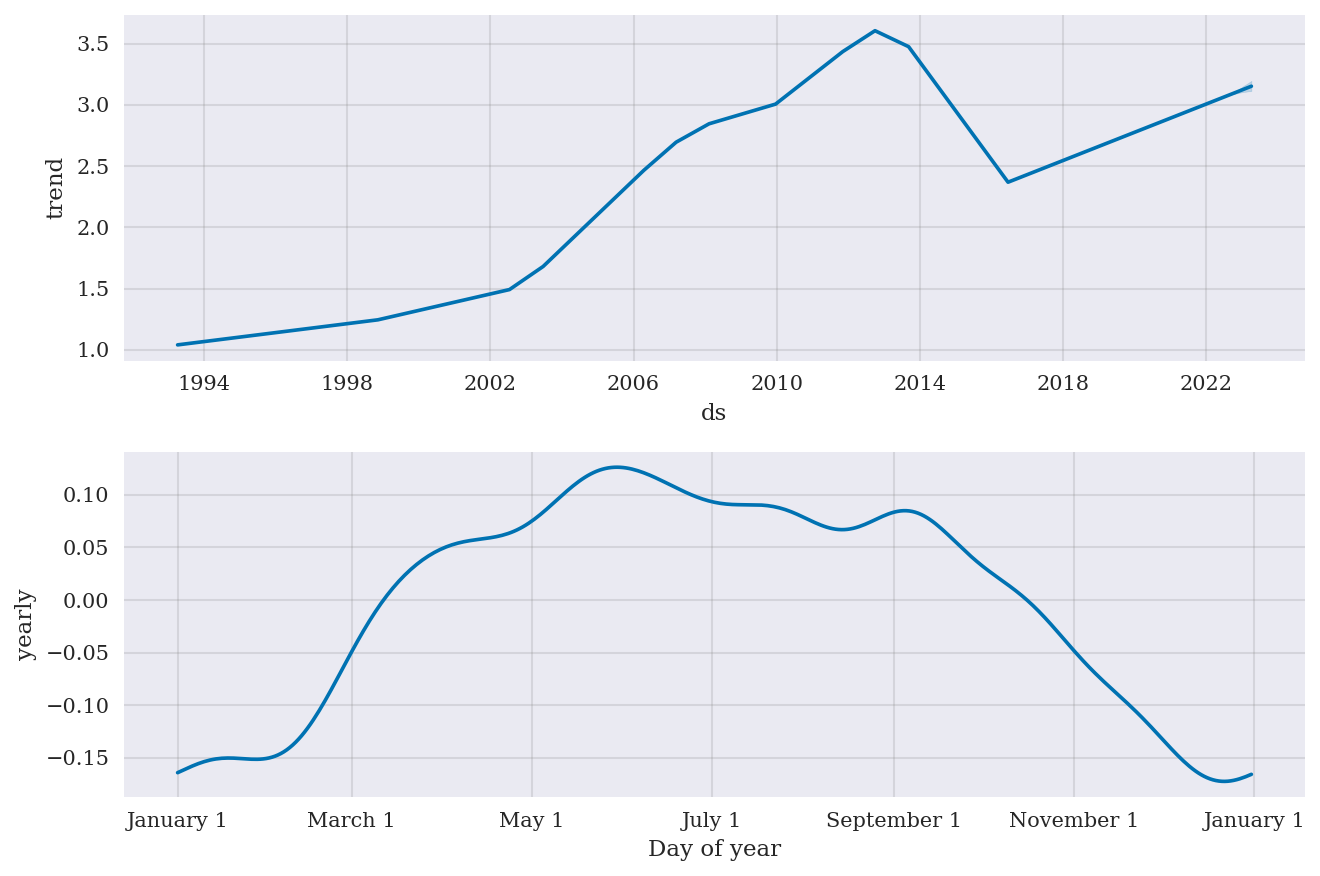

In [34]:
f = m.plot_components(m_forecast)
plt.show()

In [31]:
future_date_range = pd.date_range('2019-04-09','2023-04-09', freq='W')

predict_price = pd.DataFrame({'date':future_date_range})

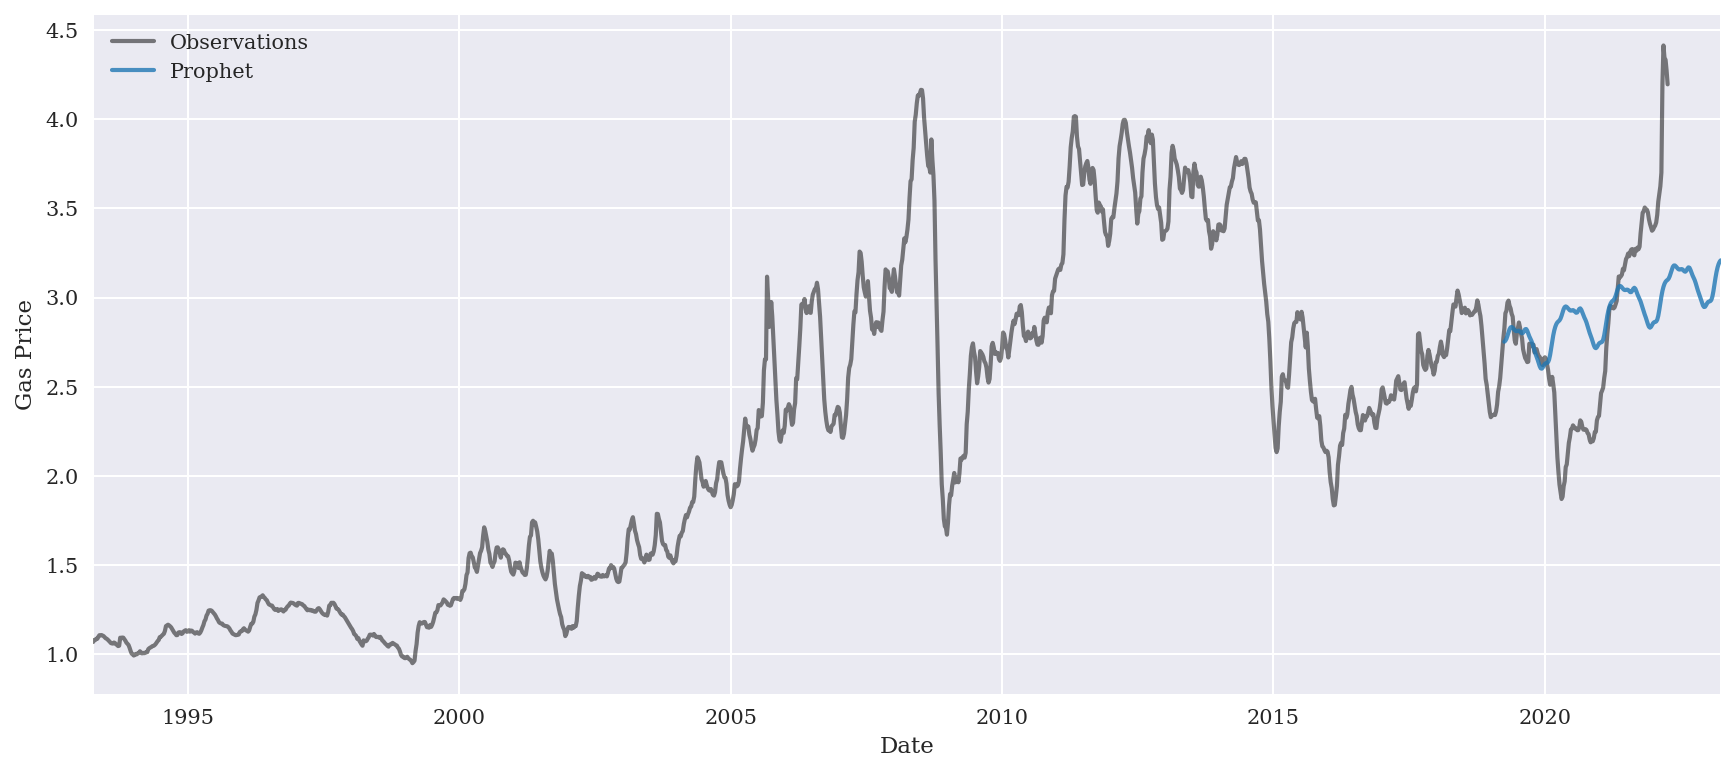

In [36]:
predict_price['m'] = m_forecast[-len(predict_price.index):]['yhat'].values

fig, ax = plt.subplots(1,1)
df.plot(x='week', y='price', c='k', label='Observations', lw=2, alpha=.5, ax=ax)
predict_price.plot(x='date', y='m', c='tab:blue', lw=2, label='Prophet', alpha=.8, ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Gas Price')

plt.show()

The predictions for the coming year will probably be wrong.

## Write-up

For Assignment 6, I've chosen the Gas Prices time series. It contains weekly the US all grades all formulations retail gasoline prices from  4/5/1993 to 4/11/2022. The date for each weekly price is the starting date of the week.  The price is dollars per gallon. Overall, there are 1515 rows, i.e., gas prices of 1515 weeks.

After importing all the libraries that I will need throughout the notebook and setting the plotting parameters for better visualizations, I loaded the dataset. Then I checked it. There were no missing values, however, the data was in reverse chronological order, i.e., new data came earlier in the dataset. So, I changed the order to restore the chronological order. The `week` column, which contains the starting date of the week, was of type `str`, so I converted it to `datetime`. Other than that, I renamed the columns because the initial names were lengthy and inconvenient to work with.

Next, I plotted all the price data to see if it is possible to find any trends or patterns just by looking at the graph. The first thing I noticed was that gasoline prices have increased more than 4 times since 1993. I could also see the effects of the 2008 financial crisis, the increase in the prices followed by a steady decrease. Other than that, gasoline prices have been increasing since 2020, and there has been a particularly significant spike since around February 2022. These are caused by the COVID-19 pandemic and the Russian invasion of Ukraine, respectively. However, I couldn’t find any seasonality by just looking at the graph. The overall trend of the prices was increasing, which is reasonable. Major events that affect the economy can be detected on the graph by just looking at it, but not the seasonality or any specific patterns.

Furthermore, I plotted the moving average for 6 months and 1 year, which should be smooth as compared to the price line making it easier to detect any patterns. However, while the major economic crises could be detected in the plots, no actual seasonality could be found just by looking at the plots. So, I decided to decompose the time series into its trend, seasonality, and residual components using the `seasonal_decompose` function from the `statsmodels` library. After plotting the results, I found out, that the trend looked quite similar to the moving average I have plotted earlier, which is reasonable. The function was able to find some annual seasonality, which seemed to be weak (scaling was -0.1 to 0.1) but I think it should be taken into account. According to said seasonality prices go up until mid-summer and then decrease. This lines up with an opinion I have heard before, which says that gasoline prices are lower in winter and higher in summer, which is because people tend to drive less during winter and more during summer. Then, I plotted some vertical lines in the gas price chart to ensure that the found seasonality is correct. And it indeed could be found in the graph: annual gas prices peaked sometime around mid-summer. Other than that, the residual component reflects the 2008 financial crisis effect, but not the recent events' impact on the price.

Then, I wanted to find the autocorrelation and partial autocorrelation for the time series to see whether it also supports the seasonality. I resampled the weekly data into monthly to make understanding the autocorrelation and partial autocorrelation plots easier. To make these plots, I used the `plot_acf` and `plot_pacf` functions of the `statsmodels` library. Even though the `seasonal_decompose` found some seasonality, the partial autocorrelation does not suggest any relationship between the time series data. Also, there are no peaks in the autocorrelation plot, which supports the claim that there is no strong seasonality.

Other than that, I have another idea to test. As far as I understand, gas prices affect account for the increase in the inflation rates. I will plot monthly inflation rates with the gasoline prices, to see the relationship between the two. However, I first need to load and check the inflation rates dataset, that I got from the US Bureau of Labor Statistics. This dataset contains monthly US inflation rates from 1/1914 to 3/2022. The dataset is like a pivot table, so I had to reshape it to make working with it easier. Besides the monthly inflation rates, the dataset contained the annual inflation rates, as well as the inflation rates for the first and second halves of the year. Since I did not need them, I dropped them. After checking the dataset and ensuring there are no missing values, I proceeded to plot both time series in one chart.

The graph showed that the time series were somewhat correlated. Even though the US economy is not as dependent on oil as it used to be, oil still is a big contributor to inflation. We can see that as gas price increases, the inflation rate also increases, and as gas price decreases, the inflation rate also decreases. Lastly, I found the Pearson correlation coefficient. Although I looked at the graph and saw a clear correlation, I do not think it was purely linear and I was not sure the Pearson correlation coefficient would be big enough. Indeed, the Pearson correlation coefficient is 0.147. The p-value of 0.0059 ensures the returned coefficient is statistically significant.

For the last part, I tried to predict future gas prices. Currently, the US economy is quite unstable because of the ban on the import of Russian oil and gas, hence predicting that future gas prices would not give good results. Nonetheless, I used Facebook's Prophet to predict the gas prices for the next year. We will be able to check how good the predictions are later. Before predicting the gas prices for the next year, I used Prophet to find the trend and seasonality. The result was good enough except for the crises times when the Prophet line was off the original price line. Consequently, the predictions made would also be wrong.

Overall, there is some seasonality in the gas price time series, and the gas price significantly affects the inflation rates, since while the US economy is not as dependent on oil as it used to be, oil still is a big contributor to inflation.